# Прогнозирование уровня диммирования уличного освещения
Нейросетевая модель для предсказания оптимального уровня освещения

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import joblib
import warnings

warnings.filterwarnings('ignore')

2025-06-03 23:56:35.476007: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-03 23:56:35.482097: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-03 23:56:35.495205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748984195.520105   80520 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748984195.526082   80520 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748984195.549100   80520 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
df = pd.read_csv('device_data.csv')
print(f"Загружено {len(df)} записей")
df.head()

Загружено 42 записей


,id,timestamp,serial_number,latitude,longitude,car_count,traffic_speed,traffic_density,pedestrian_count,pedestrian_density,ambient_light,lighting_class,lamp_power,weather,dimming_level
0,1,2025-03-02T00:00:00,1,47.22486,39.702285,9,24.38,0.11,0,0.00,151.0,B1,75.0,rain,75.0
1,2,2025-03-02T01:00:00,1,47.22486,39.702285,7,30.23,0.09,2,0.05,98.0,B1,52.5,rain,80.0
2,3,2025-03-02T02:00:00,1,47.22486,39.702285,5,21.39,0.06,0,0.00,79.0,B1,52.5,rain,75.0
3,4,2025-03-02T03:00:00,1,47.22486,39.702285,4,23.99,0.05,0,0.00,20.0,B1,52.5,rain,75.0
4,5,2025-03-02T04:00:00,1,47.22486,39.702285,1,11.50,0.01,2,0.05,7.0,B1,52.5,rain,70.0


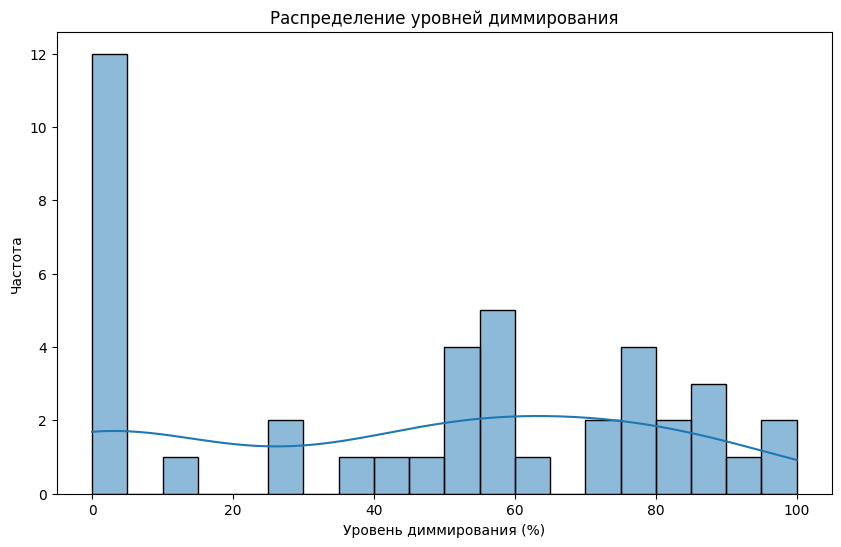

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(df['dimming_level'], bins=20, kde=True)
plt.title('Распределение уровней диммирования')
plt.xlabel('Уровень диммирования (%)')
plt.ylabel('Частота')
plt.show()

In [22]:
def prepare_data(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    y = df['dimming_level']
    X = df.drop(['id', 'timestamp', 'lamp_power', 'dimming_level'], axis=1)
    return X, y

X, y = prepare_data(df)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Тренировочный набор: {X_train.shape[0]} записей")
print(f"Тестовый набор: {X_test.shape[0]} записей")

Тренировочный набор: 33 записей
Тестовый набор: 9 записей


In [24]:
numeric_features = ['serial_number', 'latitude', 'longitude', 
                   'car_count', 'traffic_speed', 'traffic_density',
                   'pedestrian_count', 'pedestrian_density', 
                   'ambient_light', 'hour', 
                   'day_of_week', 'is_weekend']

categorical_features = ['lighting_class', 'weather']

In [25]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

input_shape = X_train_processed.shape[1]
print(f"Размерность входных данных после преобразования: {input_shape}")

Размерность входных данных после преобразования: 15


In [27]:
def build_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model

model = build_model(input_shape)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,417 (48.50 KB)

 Trainable params: 12,417 (48.50 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_processed, y_train,
    validation_data=(X_test_processed, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 3047.1951 - mae: 43.0995 - val_loss: 3230.3113 - val_mae: 48.3525
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2997.7158 - mae: 42.7159 - val_loss: 3209.5967 - val_mae: 48.2164
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3054.8218 - mae: 43.4839 - val_loss: 3191.1804 - val_mae: 48.0994
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3037.8516 - mae: 43.4242 - val_loss: 3174.2666 - val_mae: 47.9926
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3027.3347 - mae: 43.3677 - val_loss: 3158.4290 - val_mae: 47.8925
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2938.9871 - mae: 42.3975 - val_loss: 3142.9951 - val_mae: 47.7938
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2993.8687 - mae: 43.1422 - val_loss: 3126.9019 - val_mae: 47.6891
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2888.3982 - mae: 42.0421 - val_loss: 3110.0400 - val_mae: 47.5797
Epoch 9

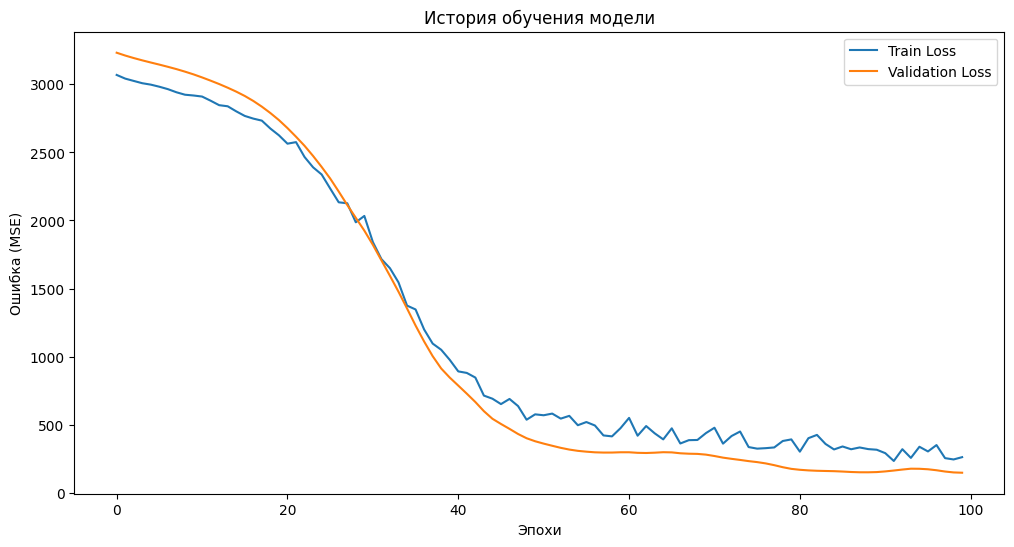

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('История обучения модели')
plt.xlabel('Эпохи')
plt.ylabel('Ошибка (MSE)')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Средняя абсолютная ошибка (MAE): 10.77
Коэффициент детерминации (R²): 0.83


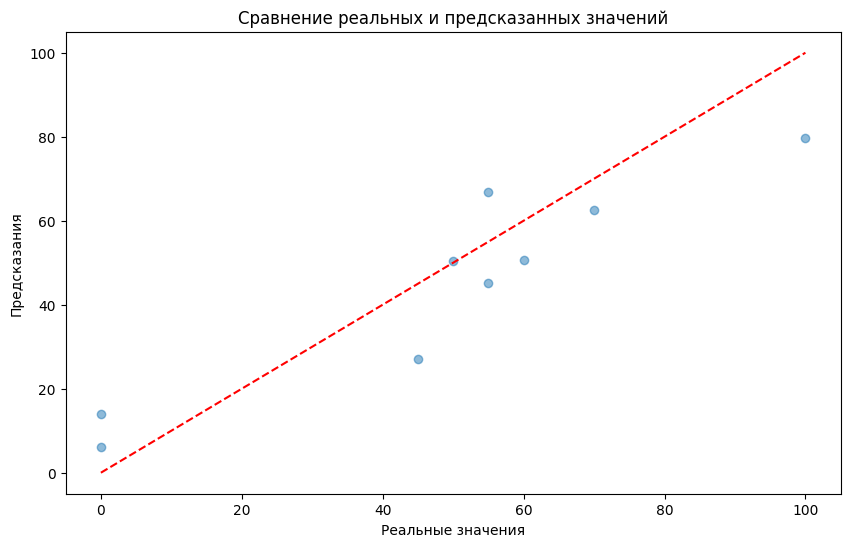

In [30]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
    print(f"Коэффициент детерминации (R²): {r2:.2f}")
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel('Реальные значения')
    plt.ylabel('Предсказания')
    plt.title('Сравнение реальных и предсказанных значений')
    plt.show()
    
    return mae, r2

mae, r2 = evaluate_model(model, X_test_processed, y_test)

In [31]:
model_data = {
    'preprocessor': preprocessor,
    'model': model,
    'input_shape': input_shape
}

model_filename = 'dimming_level_predictor.joblib'
joblib.dump(model_data, model_filename)
print(f"Модель сохранена как {model_filename}")

Модель сохранена как dimming_level_predictor.joblib


In [38]:
def predict_dimming(sample_data):
    loaded = joblib.load(model_filename)
    preprocessor = loaded['preprocessor']
    model = loaded['model']
    
    sample_df = pd.DataFrame([sample_data])
    processed_data = preprocessor.transform(sample_df)
    
    prediction = model.predict(processed_data)[0][0]
    return max(0, min(100, prediction))

sample_data = {
    'serial_number': 1,
    'latitude': 47.22486,
    'longitude': 39.702285,
    'car_count': 9,
    'traffic_speed': 24.38,
    'traffic_density': 0.11,
    'pedestrian_count': 0,
    'pedestrian_density': 0.0,
    'ambient_light': 151.0,
    'lighting_class': 'B1',
    'weather': 'rain',
    'hour': 0,
    'day_of_week': 3,
    'is_weekend': 0
}

prediction = predict_dimming(sample_data)
print(f"Предсказанный уровень диммирования: {prediction:.1f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Предсказанный уровень диммирования: 52.8%
